#  Introduction to Machine Learning: Classification with Decision Trees

**Course:** AI in AEC (Architecture, Engineering, and Construction) Summer School, ETH Zurich.

**Author:** Sophia Kuhn (sophia.kuhn@ibk.baug.ethz.ch)

In this notebook, we will explore the use of **Decision Trees** for classification tasks. Decision Trees are a popular and intuitive method for making decisions based on data. They operate by recursively splitting the dataset into subsets, creating a tree-like structure of decisions that can classify data points based on their features. 

Each node in a Decision Tree represents a decision based on a specific feature, and the branches represent the possible outcomes of those decisions. This process continues until the tree reaches a terminal node, which provides the final classification. Decision Trees are valued for their simplicity and interpretability, making them a powerful tool for both understanding and predicting data.

As an example, we will build a classification Decision Tree model that predicts the Arch Bracing type of a Network-Tied-Arch Bridge. This exercise will demonstrate how Decision Trees can be applied to real-world engineering problems, helping to make informed decisions based on the properties of different structures.

By the end of this notebook, you will understand how to build, train, and evaluate a Decision Tree classifier.

### Notebook Content


1. Import Data
2. Data Pre-Processing
3. First Decision Tree Model: Simple Tree of Low Depth
    1. Model Setup and Training
    2. Model Evaluation: Accuracy and Confusion Matrix
4. Second Decision Tree Model: Complex Tree of High Depth
    1. Model Setup and Training
    2. Model Evaluation: Overfitting
5. Grid Search with Cross Validation
    1. Finding Suitable Hyperparameters
    2. Best Model Selection
    3. Model Evaluation
6. Feature Importance








### Package Import

Import the following libraries. 

To install these packages you can run `pip install numpy pandas matplotlib seaborn scikit-learn`.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 1.  Importing Data
In this notebook, we are working with a dataset of **Network Tied-Arch Bridges** [1]. The dataset includes information on over 64 different bridges, each represented as a row in the dataset. Each bridge is described by nearly 14 different properties, with each column representing a specific property. These properties might include characteristics such as dimensions, material type, and other structural or design-related attributes. A description of the properties is provided in the image below.



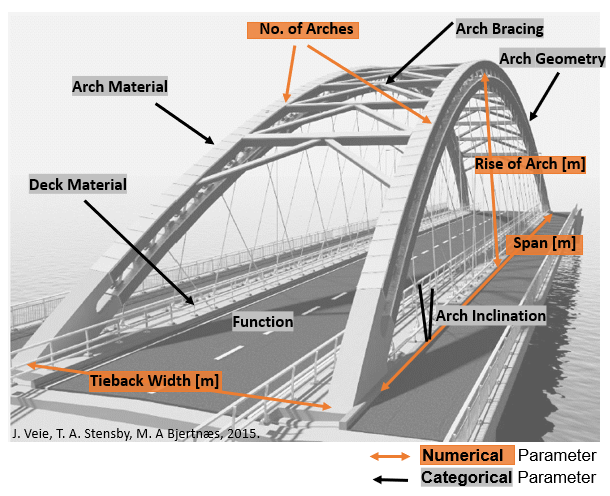

In [2]:
from IPython.display import Image
Image("BridgePropertiesDefinition.png")

In [3]:
# import the dataset as a pandas DataFrame
df = pd.read_csv("Network_TiedArchBridges_Preprocessed.csv", delimiter=';')

# show head of dataFrame
df.head()

,Name,Year,Country,Function,Material Arch,Material Deck,Coordinates N / S,Coordinates E / W,Span [m],Rise of Arch [m],Rise-Span Ratio,Width Tie Backs [m],Horizontal Arch Inclination,Arch Bracing
0,Agoishi Bridge,1985,Japan,Road Bridge,Steel,Steel-Concrete Composite,"34Â° 13' 11.52"" N","135Â° 8' 44.43"" E",163.4,26.0,6.284615,10.25,Yes,Cross Girder
1,Akio Bridge,1968,Japan,Road Bridge,Steel,Steel-Concrete Composite,"34Â° 26' 23.04"" N","132Â° 29' 0.59"" E",110.0,17.0,6.470588,6.00,Yes,Cross Girder
2,Amelia Earhart Bridge,2012,USA,Road Bridge,Steel,Steel-Concrete Composite,"39Â°33'34.0""N","95Â°06'48.4""W",160.6,26.5,6.060377,23.80,No,Diamond Truss
3,Ã…snes Bridge,2011,Norway,Road Bridge,Steel,Steel-Concrete Composite,"64Â°18'34.7""N","11Â°13'06.3""E",111.0,18.0,6.166667,9.00,No,K-Truss
4,Bent Bridge 1,2011,USA,Pedestrian Bridge,Steel,Reinforced Concrete,"37Â°19'33.7""N","121Â°51'38.9""W",82.3,6.7,12.283582,4.20,Yes,Diamond Truss


As an example we built a classification decision tree model that predicts the `Arch Bracing` type of a Network-Tied-Arch Bridge.

## 2. Data Preprocessing

In [4]:
# extract features of interest
cols=['Function','Span [m]','Rise of Arch [m]','Rise-Span Ratio',
     'Width Tie Backs [m]', 'Arch Bracing']
df_class = pd.DataFrame(df[cols])
df_class.head(67)

,Function,Span [m],Rise of Arch [m],Rise-Span Ratio,Width Tie Backs [m],Arch Bracing
0,Road Bridge,163.4,26.0,6.284615,10.25,Cross Girder
1,Road Bridge,110.0,17.0,6.470588,6.00,Cross Girder
2,Road Bridge,160.6,26.5,6.060377,23.80,Diamond Truss
3,Road Bridge,111.0,18.0,6.166667,9.00,K-Truss
4,Pedestrian Bridge,82.3,6.7,12.283582,4.20,Diamond Truss
...,...,...,...,...,...,...
59,Road Bridge,49.8,7.2,6.916667,20.70,NaN
60,Road Bridge,100.3,20.0,5.015000,12.75,K-Truss
61,Road Bridge,253.0,39.5,6.405063,20.70,Diamond Truss
62,Railway Bridge,219.0,42.0,5.214286,32.00,Cross Girder


<Axes: xlabel='count', ylabel='Arch Bracing'>

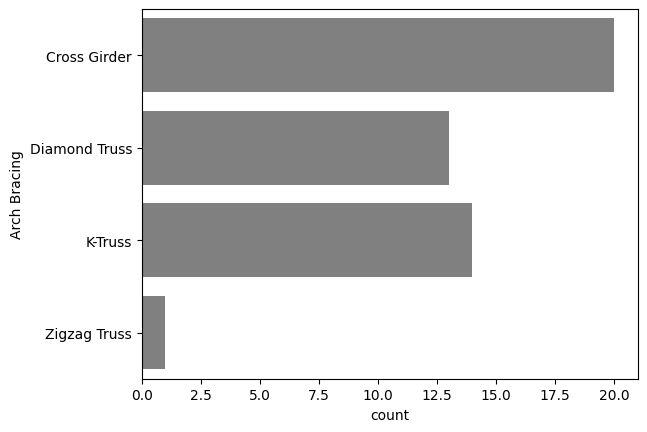

In [5]:
# plot 'Arch Bracing' feature
sns.countplot(y='Arch Bracing', data=df_class,color='grey')

<Axes: xlabel='count', ylabel='Arch Bracing'>

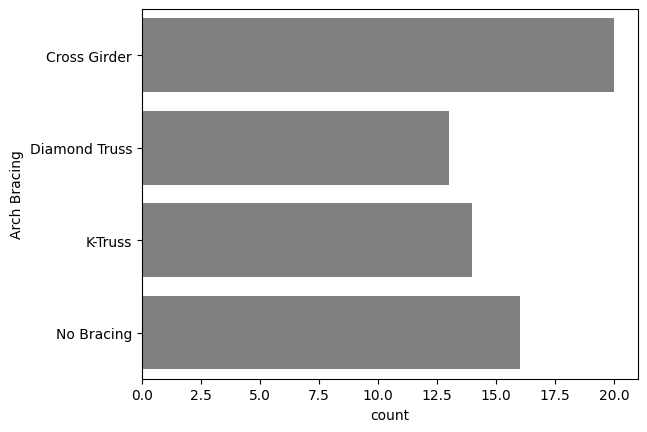

In [6]:
# Drop rows where 'Arch Bracing' is 'ZigzagTruss' (as category appears only once)
df_class=df_class[df_class['Arch Bracing'] != 'Zigzag Truss']

# Replace NaN values in the 'Arch Bracing' column with the category 'No Bracing'
df_class['Arch Bracing'] = df_class['Arch Bracing'].fillna('No Bracing')

# plot
sns.countplot(y='Arch Bracing', data=df_class,color='grey')


In [7]:
# Splitting the data in training and test set

# import splitting function
from sklearn.model_selection import train_test_split

# get columns
y = df_class['Arch Bracing']
X = df_class.drop(['Arch Bracing'],axis=1)

# split data (70% training set; 30% test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify =df_class['Arch Bracing'],
                                                    random_state=88)

# Note: "stratify" makes sure that each set contains approximately the same percentage of samples of each category.

# print
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44, 5), (19, 5), (44,), (19,))

In [8]:
# Encoding of categorical features (create dummy variables)
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
X_train.head()

,Span [m],Rise of Arch [m],Rise-Span Ratio,Width Tie Backs [m],Function_Railway Bridge,Function_Road Bridge
62,219.0,42.00,5.214286,32.0,True,False
21,158.0,26.00,6.076923,21.7,False,True
54,49.8,7.20,6.916667,20.7,False,True
44,73.5,12.25,6.000000,18.5,False,True
30,192.8,30.00,6.426667,8.0,False,True


## 3. First Decision Tree Model 
### 3.1 Model setup and training

#### Splitting Criterion: Gini Index

For this Decision Tree, we use the `Gini Index` as the splitting criterion. The Gini Index is a measure of impurity or diversity, used to decide where to split the data at each node. A lower Gini Index value indicates a purer node (i.e., most samples belong to a single class). The tree-building algorithm aims to reduce the Gini Index as it partitions the dataset, resulting in more homogeneous groups at each split.

#### Model Configuration

We configure our Decision Tree classifier with the following parameters:

- **`min_samples_leaf`**: This parameter specifies the minimum number of samples that must be present in a leaf node. Setting a minimum value helps prevent the model from overfitting by ensuring that splits that create very small leaf nodes are avoided.

- **`random_state`**: Setting a random state ensures that the results are reproducible. This parameter controls the randomness involved in training the tree, such as the order of data points and random feature selection.

- **`criterion`**: Defined the criterion for measuring the quality of splits. This helps the tree decide how to split the data at each node.

- **`max_depth`**: This parameter limits the maximum depth of the tree, i.e., how many levels of splits the tree can have. By setting a limit on the depth, we can control the complexity of the model, which can help to prevent overfitting and improve generalization.

- **`ccp_alpha`**: This parameter is used for post-pruning the tree. A positive `ccp_alpha` value will prune the tree to reduce complexity, which can also help prevent overfitting.


In [9]:
#import function
from sklearn.tree import DecisionTreeClassifier

# configure model
dt_1= DecisionTreeClassifier(min_samples_leaf=5,
                             random_state = 88,
                             criterion = 'gini',
                             max_depth=3,
                             ccp_alpha = 0.1)

# fit model
dt_1 = dt_1.fit(X_train, y_train)

Node count = 3


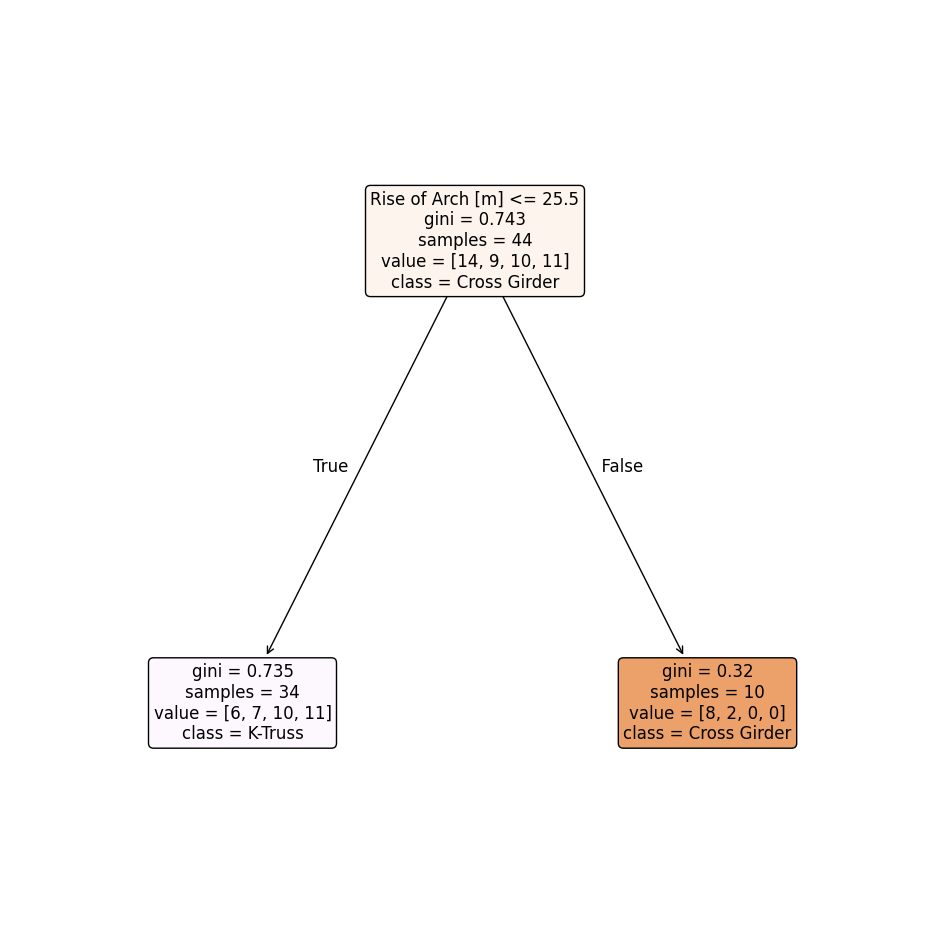

In [10]:
# plot trained desision tree
from sklearn.tree import plot_tree

print('Node count =', dt_1.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dt_1, 
          feature_names=X_train.columns, 
          class_names=y_train.unique(), 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

### 3.1 Model evaluation

To evaluate the performance of our Decision Tree classifier, we will use the **accuracy** metric. The **Accuracy** measures the proportion of correctly predicted instances out of the total instances and is defined as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

Accuracy gives us a straightforward understanding of how well the model is performing on both the training and test datasets.


In [11]:
# make predictions with trained model
y_pred_train = dt_1.predict(X_train)
y_pred_test = dt_1.predict(X_test)

In [12]:
# calculate evaluation metrics
from sklearn.metrics import accuracy_score

acc_train=accuracy_score(y_train, y_pred_train)
acc_test=accuracy_score(y_test, y_pred_test)
print('Acc_train:',round(acc_train,5))
print('Acc_test:',round(acc_test,5))

Acc_train: 0.43182
Acc_test: 0.42105


In addition to accuracy, a **confusion matrix** provides a more detailed breakdown of the model's performance by showing the number of true positive, true negative, false positive, and false negative predictions. This allows us to see not only the accuracy but also where the model is making errors.

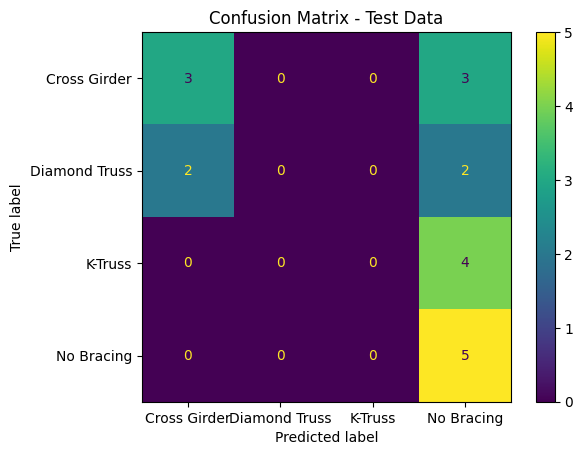

In [13]:
# Import confusion matrix plotting utilities
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=dt_1.classes_)
cm_display_test.plot()
plt.title("Confusion Matrix - Test Data")
plt.show()

## 4. Second Decision Tree Model

For the second model, we adjust the parameters to explore how they affect the performance of the Decision Tree.


### 4.1 Model setup and training


In [14]:
dt_2= DecisionTreeClassifier(min_samples_leaf=2,
                             random_state = 88,
                             criterion = 'gini',
                             max_depth=100,
                             ccp_alpha = 0.0001)

dt_2 = dt_2.fit(X_train, y_train)

Node count = 27


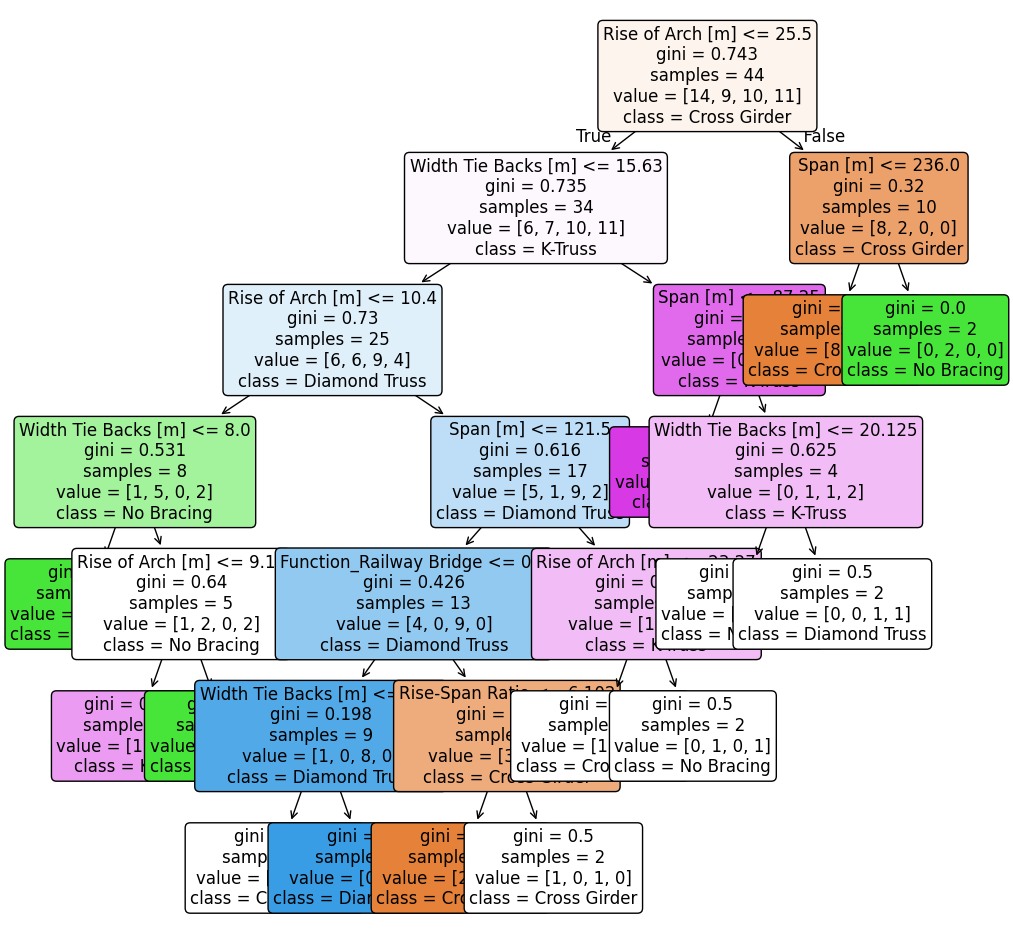

In [15]:
print('Node count =', dt_2.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dt_2, 
          feature_names=X_train.columns, 
          class_names=y_train.unique(), 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()


### 4.2 Model evaluation

In [16]:
# make predictions with trained model
y_pred_train = dt_2.predict(X_train)

y_pred_test = dt_2.predict(X_test)

In [17]:
# calculate evaluation metrics
from sklearn.metrics import accuracy_score

acc_train=accuracy_score(y_train, y_pred_train)
acc_test=accuracy_score(y_test, y_pred_test)
print('Acc_train:',round(acc_train,5))
print('Acc_test:',round(acc_test,5))

Acc_train: 0.84091
Acc_test: 0.63158


From these results, we can observe that the model's performance is significantly lower on the test data compared to the training data, which indicates overfitting. 
Fine-tuning the parameters can help achieve a better balance between model complexity and generalization, leading to improved performance across different datasets.

## 5. Grid Search with Cross Validation

To fine-tune our Decision Tree model and achieve a better balance between complexity and generalization, we use **Grid Search** to optimize the `ccp_alpha` parameter, which controls tree pruning. Pruning helps to simplify the tree by removing sections that provide little predictive power, thereby reducing overfitting.

**Grid Search** works by testing multiple values of `ccp_alpha` to find the best one. In this example, we define a range of `ccp_alpha` values to test. For each value, the model is evaluated using **10-fold cross-validation** to ensure robustness and prevent overfitting.

**10-fold Cross Validation** involves splitting the training set into 10 equal parts. The model is trained on 9 parts and validated on the remaining part, repeating this process 10 times so that each part serves as the validation set once (see image below). The average validation accuracy is used to determine the best `ccp_alpha` value, ensuring that the selected model performs well on unseen data.

By using Grid Search and Cross Validation, we can systematically identify the `ccp_alpha` value that optimizes our model's performance, leading to a more accurate and generalizable Decision Tree.


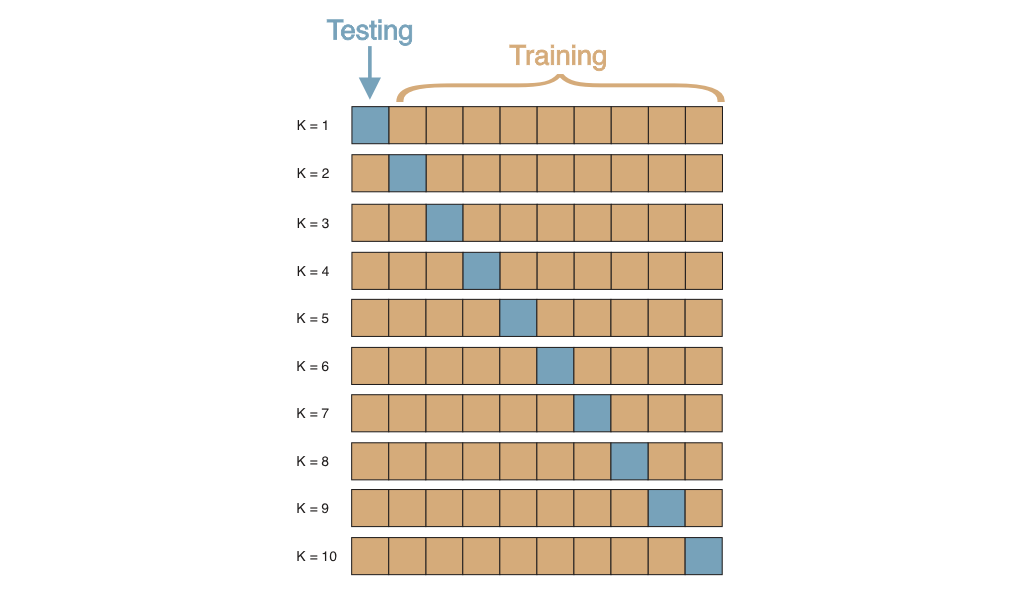

In [18]:
from IPython.display import Image
Image("10_foldCrossValidation.png") # from [3]

### 5.1 Find suitable hyperparameter 

In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Grid Search
grid_values = {
    'ccp_alpha': np.linspace(0.0, 0.10, 50),  # Range of ccp_alpha values to test
    'min_samples_leaf': [5],                  # Keeping other parameters constant
    'min_samples_split': [20],
    'max_depth': [3],
    'random_state': [88]
}

# Initialize a DecisionTreeClassifier without setting ccp_alpha explicitly
dt_3 = DecisionTreeClassifier()

# Initialize GridSearchCV with DecisionTreeClassifier and the parameter grid (10-fold)
dtc_cv_acc = GridSearchCV(dt_3, param_grid=grid_values, scoring='accuracy', cv=10, verbose=1)

# Fit the GridSearchCV to the training data
dtc_cv_acc.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\Users\kuhnso\AppData\Local\anaconda3\envs\AIinAEC\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00204082, 0.00408163, 0.00612245, 0.00816327,
       0.01020408, 0.0122449 , 0.01428571, 0.01632653, 0.01836735,
       0.02040816, 0.02244898, 0.0244898 , 0.02653061, 0.02857143,
       0.03061224, 0.03265306, 0.03469388, 0.03673469, 0.03877551,
       0.04081633, 0.04285714, 0.04489796, 0.04693878, 0.04897959,
       0.05102041, 0.05306122, 0.05510204, 0.05714286, 0.05918367,
       0.06122449, 0.06326531, 0.06530612, 0.06734694, 0.06938776,
       0.07142857, 0.07346939, 0.0755102 , 0.07755102, 0.07959184,
       0.08163265, 0.08367347, 0.08571429, 0.0877551 , 0.08979592,
       0.09183673, 0.09387755, 0.09591837, 0.09795918, 0.1       ]),
                         'max_depth': [3], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

In [20]:
# Retrieve the mean test scores for each parameter setting
acc = dtc_cv_acc.cv_results_['mean_test_score']

# Retrieve the corresponding ccp_alpha values tested
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

# Display the last 10 ccp_alpha values and their corresponding validation accuracy
# This helps us see how accuracy changes with different pruning levels
pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).tail(10)

,ccp alpha,Validation Accuracy
40,0.081633,0.360
41,0.083673,0.360
42,0.085714,0.385
43,0.087755,0.340
44,0.089796,0.340
45,0.091837,0.340
46,0.093878,0.340
47,0.095918,0.290
48,0.097959,0.290
49,0.100000,0.290


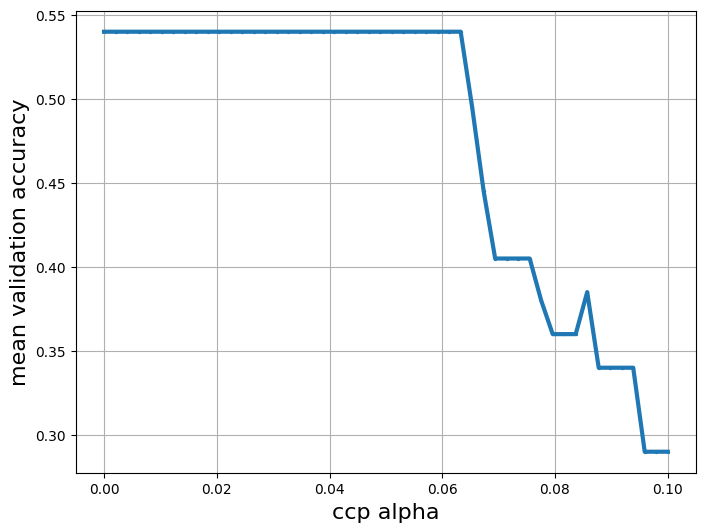

In [21]:
# Plot the mean validation accuracy against ccp_alpha values
# This plot helps visualize the relationship between ccp_alpha and model performance
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

### 5.2 Best Model

The value of `ccp_alpha` is chosen that results in the highest accuracy score.

In [22]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0
Grid best score (accuracy):  0.54


Node count = 7


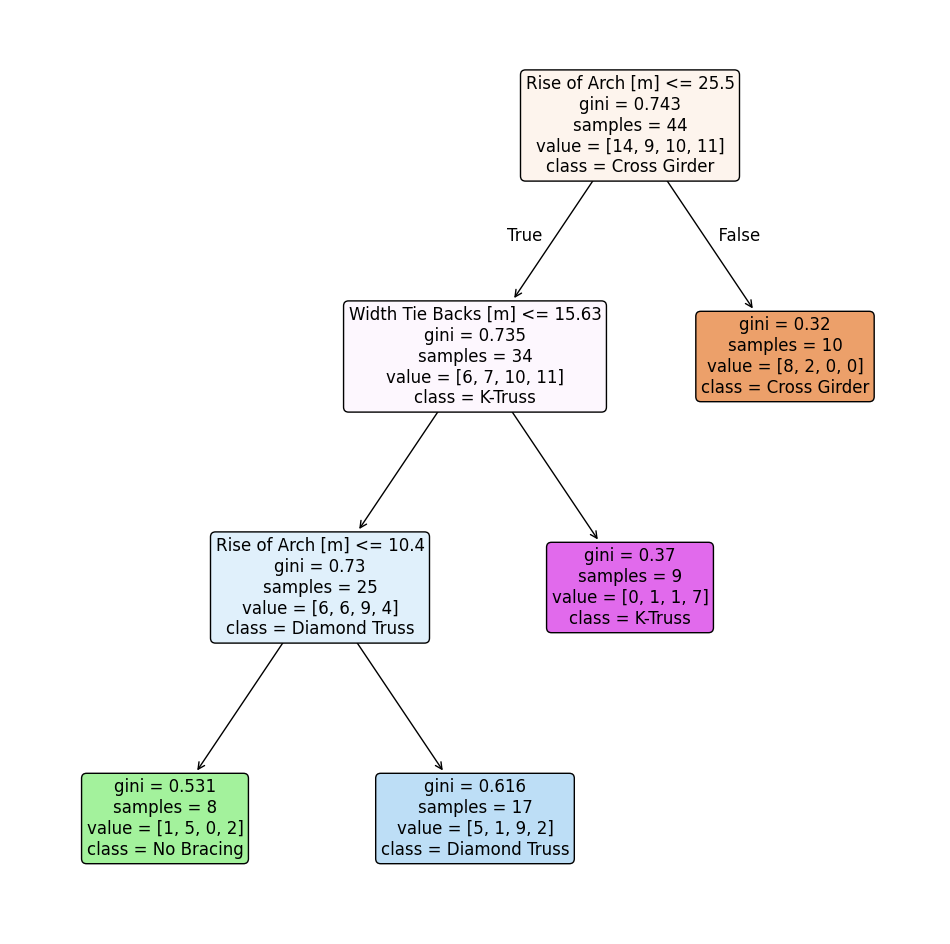

In [23]:
# Plot the decision tree with the best parameters
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=y_train.unique(), 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

### 5.3 Model evaluation

In [24]:
# Make predictions with the best model found by GridSearch
y_pred_train = dtc_cv_acc.best_estimator_.predict(X_train)
y_pred_test = dtc_cv_acc.best_estimator_.predict(X_test)

In [25]:
# Calculate and print accuracy for training and test sets
from sklearn.metrics import accuracy_score

acc_train=accuracy_score(y_train, y_pred_train)
acc_test=accuracy_score(y_test, y_pred_test)
print('Acc_train:',round(acc_train,5))
print('Acc_test:',round(acc_test,5))

Acc_train: 0.65909
Acc_test: 0.63158


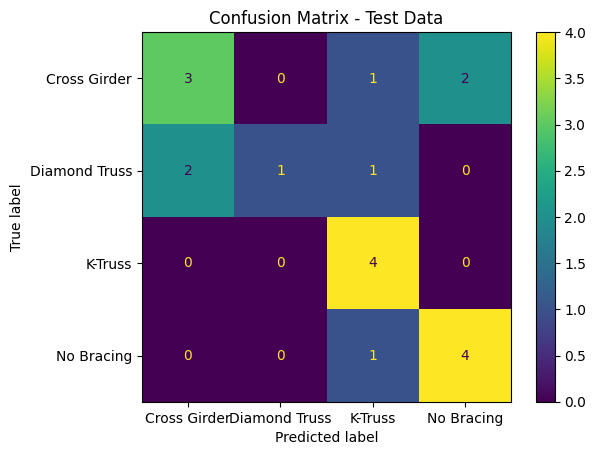

In [26]:
# Generate confusion matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=dt_1.classes_)
cm_display_test.plot()
plt.title("Confusion Matrix - Test Data")
plt.show()

## 6.  Feature Importance

Feature importance helps us understand which features have the most significant impact on the model's predictions. By examining the importance scores, we can identify the key factors that influence the classification decisions made by the Decision Tree. This insight can be valuable for understanding the underlying patterns in the data and for making informed decisions about feature selection and model refinement.

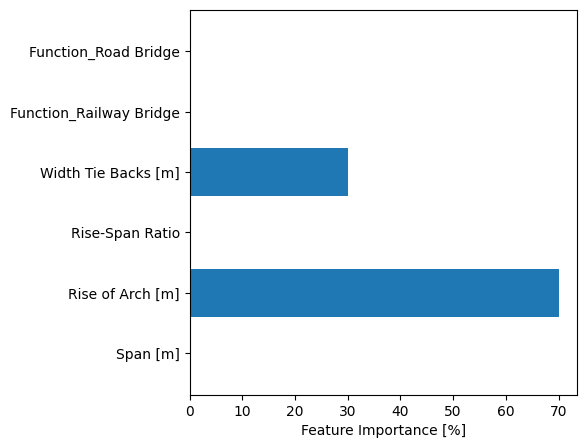

In [27]:
# plot feature importance
plt.figure(figsize=(5,5))
plt.barh(X_train.columns, 100*dtc_cv_acc.best_estimator_.feature_importances_)
plt.xlabel('Feature Importance [%]')
plt.show()

# References
- [2] Kuhn, Sophia: Parametric Modelling and Generative Design - A Multi-Step Machine Learning Approach for Design and Optimization of Network Tied-Arch Bridges. Master's Thesis. IBK, ETH Zurich, 2021.
- [3] https://towardsdatascience.com/the-importance-of-k-fold-cross-validation-for-model-prediction-in-machine-learning-4709d3fed2ef
 
    